# Assignment 1

Due Friday 5th August 23:59

## Assignment Outline

### Explore data
* Inspect the shape and types of data
* Visualization
* Value counts
### Clean data
* null
* nonsensical 
### Understand data
* Find relationships
    * Correlation
    * Mean house price against categorical levels
* Feature engineering
    * livingArea and bedrooms variable?
    * lotSize and landValue variable?


In [2]:
import csv
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

## Import CSV

In [3]:


with open("data.csv", 'r') as data:
    header = csv.reader(data).__next__()

# remove unnamed row.
houses = pd.read_csv('data.csv', usecols=header[1:])

## Splitting the data

In [4]:

X = houses.drop(["price"], axis = 1) # indepedent features
y = houses["price"].copy          # dependent variable

train_set, test_set = train_test_split(houses, test_size=0.2, random_state=0)


In [5]:
train_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1649,153000,0.11,16,2900,1480,40,2,0,2.5,4,hot air,gas,public/commercial,No,No,No
1465,223000,0.33,18,27000,1360,40,3,1,1.5,8,electric,electric,public/commercial,No,No,No
361,178500,1.00,12,32000,1952,71,3,2,2.0,9,hot air,oil,septic,No,No,No
315,168500,0.44,34,31800,1586,64,3,1,1.5,7,hot air,gas,public/commercial,No,No,No
1372,167500,0.16,18,15100,1492,40,3,0,2.5,6,electric,electric,public/commercial,No,No,No


In [6]:
test_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1318,229900,0.44,7,24200,1328,64,3,1,2.5,8,hot air,gas,public/commercial,No,No,No
124,158000,0.52,0,4400,2098,44,3,0,2.0,7,hot air,gas,septic,No,Yes,Yes
648,367500,0.27,2,78200,2205,57,3,1,2.5,10,hot air,gas,public/commercial,No,No,Yes
249,128850,0.92,16,5500,824,45,3,0,1.5,5,electric,electric,septic,No,No,No
1599,290000,0.61,34,32300,2728,64,4,1,2.5,10,hot water/steam,gas,public/commercial,No,No,No


## Explore the Training Set

There are 1105 rows and 16 features of the training set. There are no missing values.

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 1649 to 684
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1382 non-null   int64  
 1   lotSize          1382 non-null   float64
 2   age              1382 non-null   int64  
 3   landValue        1382 non-null   int64  
 4   livingArea       1382 non-null   int64  
 5   pctCollege       1382 non-null   int64  
 6   bedrooms         1382 non-null   int64  
 7   fireplaces       1382 non-null   int64  
 8   bathrooms        1382 non-null   float64
 9   rooms            1382 non-null   int64  
 10  heating          1382 non-null   object 
 11  fuel             1382 non-null   object 
 12  sewer            1382 non-null   object 
 13  waterfront       1382 non-null   object 
 14  newConstruction  1382 non-null   object 
 15  centralAir       1382 non-null   object 
dtypes: float64(2), int64(8), object(6)
memory usage: 183.5+ KB

#### Analyze Distributions

livingArea[5], pctCollege[6], bedrooms[7], fireplaces[8], bathrooms[9] and rooms[10] are approximately normally distributed.
Price[1], lotSize[2], age[3], landValue[4] are right skewed and could use normalizing.

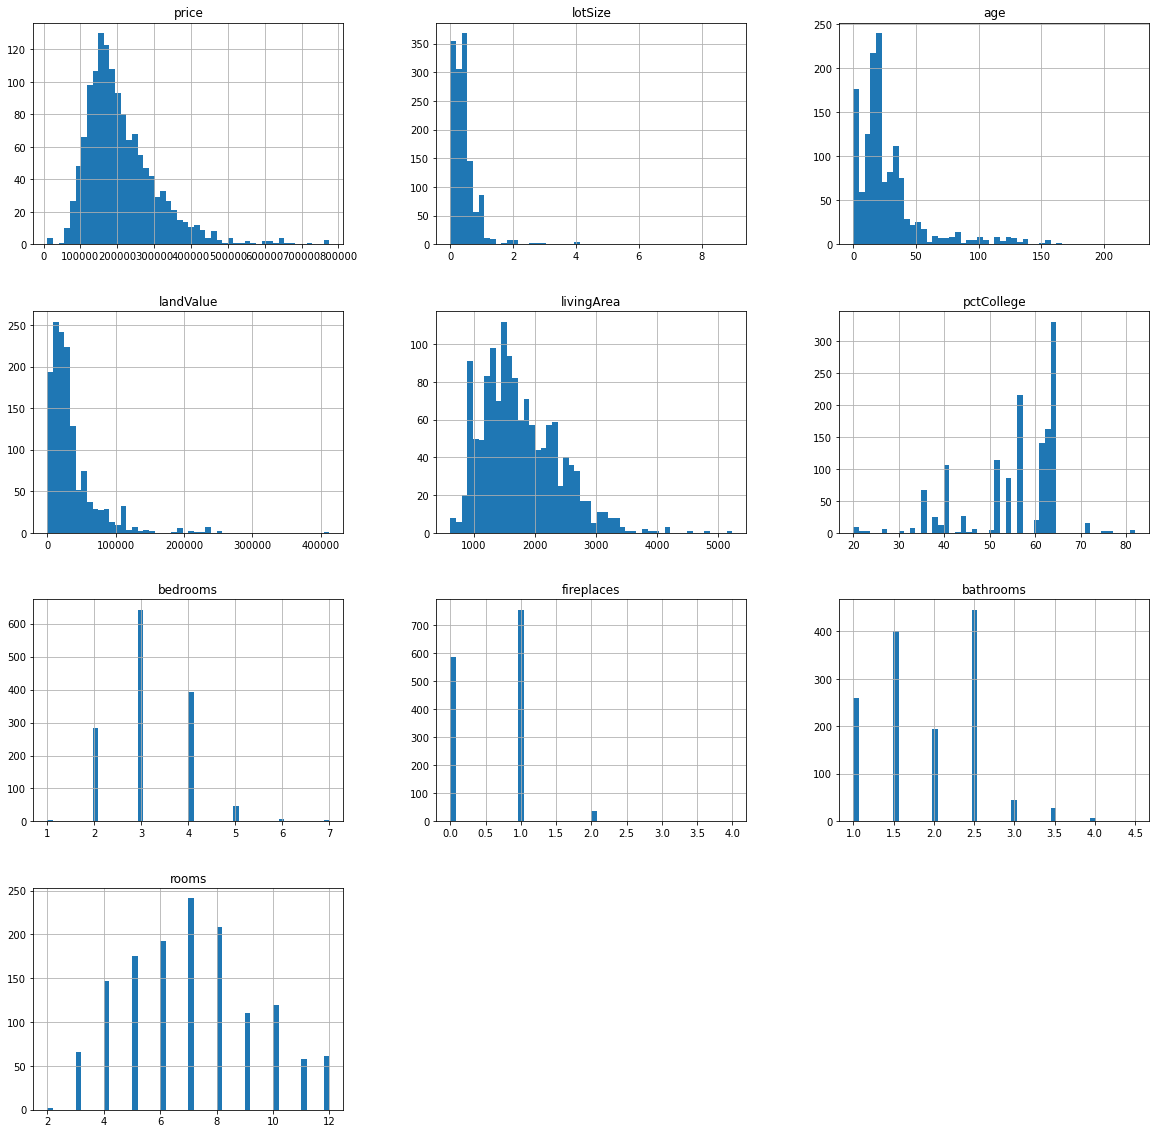

In [8]:
train_set.hist(bins = 50, figsize = (20,20))
fig = plt.gcf() 
fig.savefig('hist.pdf', bbox_inches = 'tight')

Below emphasises the right tail skew in features 1, 2, 3 and 4. They all have a disproportionately large spread and very large values.


In [9]:
train_set.describe()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,211977.407381,0.495904,27.996382,35266.005789,1758.619392,55.685962,3.164978,0.610709,1.904848,7.049204
std,99608.842830,0.661244,29.182973,36616.276086,625.841288,10.316558,0.834791,0.564815,0.661465,2.330519
min,10300.000000,0.000000,0.000000,300.000000,616.000000,20.000000,1.000000,0.000000,1.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1297.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,188900.000000,0.370000,19.000000,25100.000000,1643.000000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259106.500000,0.540000,34.000000,40875.000000,2179.000000,64.000000,4.000000,1.000000,2.500000,9.000000
max,775000.000000,8.970000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


#### Understand Correlation

livingArea is correlated with multiple other features which may have a negative affect on our model. Bedrooms and rooms may also affect our model negatively. I would like to see how the model performs both with and without these features.

<AxesSubplot:>

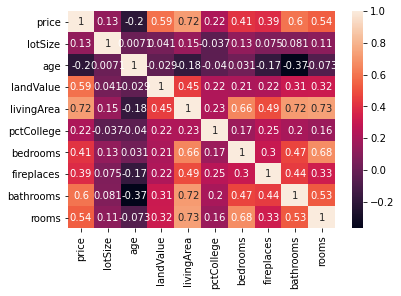

In [10]:
sns.heatmap(train_set.corr(), annot=True)

#### Understand Categorical Data

It may be useful to see how the frequency of the categorical levels compare.

In [11]:


my_selector = selector(dtype_include=object)
categorical = my_selector(train_set)

# print the levels of the categorical variables
def levels(df, features):
    [print(feature, df[feature].unique()) for feature in features]

levels(train_set, categorical)


heating ['hot air' 'electric' 'hot water/steam']
fuel ['gas' 'electric' 'oil']
sewer ['public/commercial' 'septic' 'none']
waterfront ['No' 'Yes']
newConstruction ['No' 'Yes']
centralAir ['No' 'Yes']


Barcharts are created to see how these levels balance.

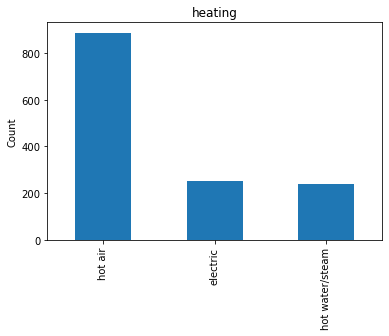

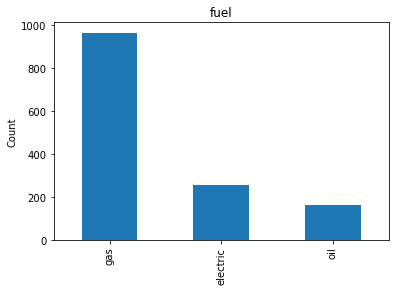

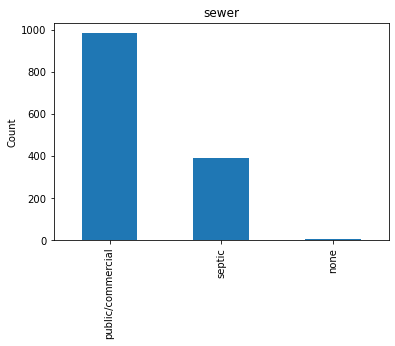

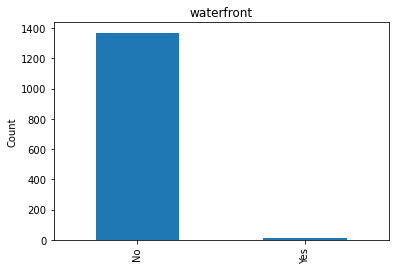

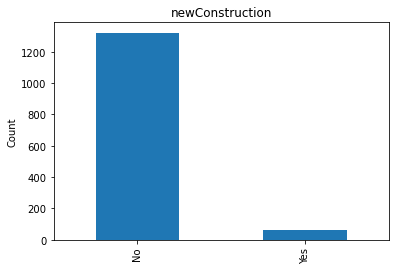

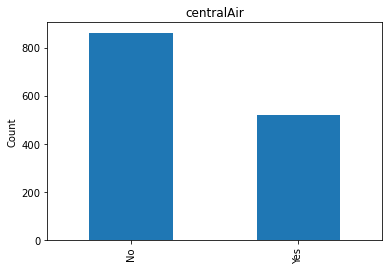

In [12]:
def plot_categorical(df, features):
    for feature in features:
        df[feature].value_counts().plot(kind='bar')
        plt.title(feature)
        plt.ylabel('Count')
        plt.show()
plot_categorical(train_set, categorical)



Compare categorical levels with their mean price

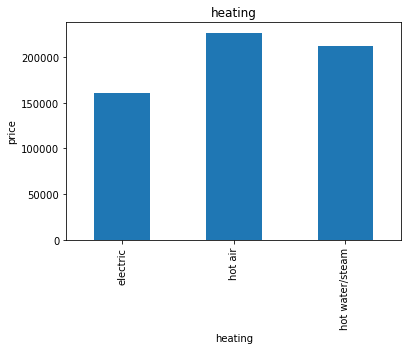

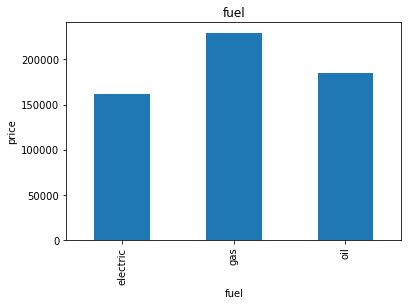

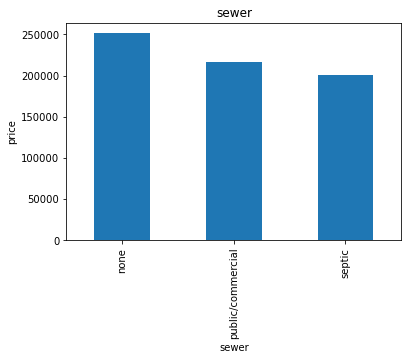

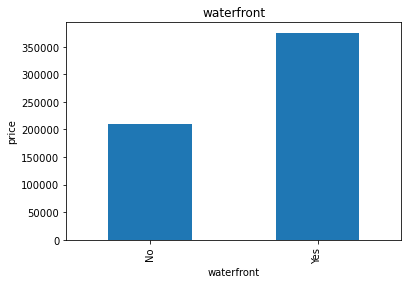

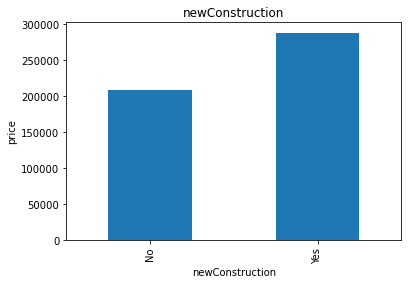

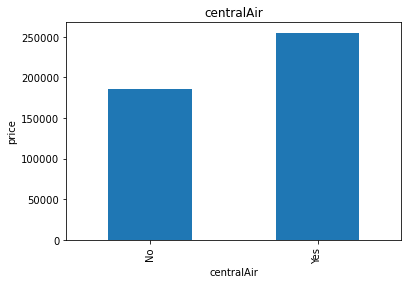

In [13]:
def compare_categorical(df, features, target):
    for feature in features:
        df.groupby(feature).mean()[target].plot(kind='bar')
        plt.title(feature)
        plt.ylabel(target)
        plt.show()
compare_categorical(train_set, categorical, 'price')


## Pipeline

#### Dropping Labels

Separate the predictors and the labels since we don't
necessarily want to apply the same transformations
to the predictors and the target values.

In [14]:
X_train = train_set.drop("price", axis=1) # drop labels for training set
y_train = train_set["price"].copy()
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

### Transform Data

#### Get different types of data

In [15]:
# splits the data into categorical and numerical features
def split_columns(df):
      my_selector = selector(dtype_include=int)
      numerical_int = my_selector(df)
      my_selector = selector(dtype_include=float)
      numerical_float = my_selector(df)
      my_selector = selector(dtype_include=object)
      categorical = my_selector(df)
      return numerical_int, numerical_float, categorical

numerical_int, numerical_float, nominal = split_columns(X_train)
print("Features length:", len(X_train.columns), "\nCollected data: ",
      len(numerical_int) + len(nominal) + len(numerical_float))
numerical = numerical_int + numerical_float
print("Numerical: ", len(numerical))
print("Nominal:",len(nominal))


Features length: 15 
Collected data:  8
Numerical:  2
Nominal: 6


#### Make Pipelines

We have all the data separated into their corresponding groups. Note that all of our categorical variables are nominal, so we do not need an ordinal pipeline.

In [16]:
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())])
# one hot encoder to convert nominal data into binary data.
nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])


#### Create pre-processor and Model

Create the column transformer to simplify our data into all numerical

In [17]:
preprocessor = ColumnTransformer([
    ('numerical_transformer', numerical_pipeline, numerical),
    ('nominal_transformer', nominal_pipeline, nominal)
])
preprocessor

ColumnTransformer(transformers=[('numerical_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['lotSize', 'bathrooms']),
                                ('nominal_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['heating', 'fuel', 'sewer', 'waterfront',
                                  'newConstruction', 'centralAir'])])

Our data is ready for a model to fit to it. Transform our data into all numerical, perform scaling and fill in missing values. Afterward fit the training data to a linear regression model.

In [18]:
# transform columns and fit the model
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lotSize', 'bathrooms']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                       

## Tune Parameters

### Grid Search CV

In [19]:
# lr_model.get_params().keys()
param_grid = [
    {'regressor__fit_intercept': [True, False],
     'regressor__copy_X': [True, False],
     'regressor__n_jobs': [1, -1],
     'regressor__positive': [True, False]}
]
grid_search = GridSearchCV(lr_model, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['lotSize',
                                                                          'bathrooms']),
                                                                        ('nominal_transformer',
                                                                         Pipeline(steps=[('imputer',
                                    

In [20]:
grid_search.best_params_

{'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': 1,
 'regressor__positive': False}

In [21]:
np.sqrt(abs(grid_search.best_score_))

76455.36808746366

In [22]:
grid_search.best_estimator_.named_steps['regressor']

LinearRegression(n_jobs=1)

### Random Search CV

## Make Predictions & Evaluate

### Training Set

#### Predict with Linear Regression

In [23]:
def metrics(model, predictions, X, y):
    RMSE = np.sqrt(mean_squared_error(y, predictions))
    MAPE = (np.mean(np.abs((y - predictions) / y))) * 100
    R_squared = model.score(X, y)
    return pd.DataFrame({"RMSE": RMSE, "MAPE": MAPE, "R^2": R_squared}, index = ["Linear Regression"])
    
lr_model.fit(X_train, y_train)
train_predictions = lr_model.predict(X_train)
metrics(lr_model, train_predictions, X_train, y_train)


,RMSE,MAPE,R^2
Linear Regression,75504.164811,30.224527,0.42501


In [24]:
y_train_predicted = lr_model.fit(X_train, y_train).predict(X_train)

# display actual vs predicted and the residuals
def summarize_results(y_train, y_train_predict):
    return pd.DataFrame({'Actual': y_train, 'Predicted': y_train_predict,
                        'Difference': abs(y_train - y_train_predict),
                        'Difference_percent': (abs(y_train - y_train_predict)/y_train*100)})

results = summarize_results(y_train, y_train_predicted)
print("On average, our model has", round((results['Difference_percent'].mean()), 4), '% error (MAPE)')
results.sample(5)

On average, our model has 30.2245 % error (MAPE)


,Actual,Predicted,Difference,Difference_percent
548,512971,234919.083911,278051.916089,54.204217
448,159000,167595.595116,8595.595116,5.406035
1275,249900,273215.940040,23315.940040,9.330108
157,89900,137538.357749,47638.357749,52.990387
1107,245000,121323.638928,123676.361072,50.480147


#### Visualizing Predictions vs Actual

The model tends to under-estimate for higher values. This is typical when the target value does not follow a normal distribution. Hence, we should normalize price.

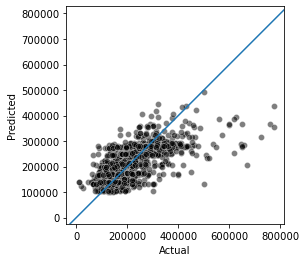

In [25]:
def plot_residuals(results):
    sns.scatterplot(y='Predicted', x='Actual', data=results,
                      color="black", alpha=0.5)
    plt.axline((0, 0), slope=1, label="Perfect fit")
    plt.axis('square')
    plt.show()
plot_residuals(results)

#### Scale Target variable and check predictions again

In [26]:
quantile_transformer = QuantileTransformer(n_quantiles=1000, output_distribution="normal")
model_transformed_target = TransformedTargetRegressor(regressor=lr_model,
                                                      transformer=quantile_transformer)
model_transformed_target.fit(X_train, y_train)
y_train_predicted = model_transformed_target.predict(X_train)

Once the model get scaled, it has about MAPE, but R^2 is about 0.05 worse and RMSE is about 5000 worse. Hence, we'll try not scaling the data.

In [27]:
metrics(model_transformed_target, y_train_predicted, X_train, y_train)

,RMSE,MAPE,R^2
Linear Regression,75988.314296,27.890368,0.417612


In [28]:
results_adjusted = summarize_results(y_train, y_train_predicted)
results_adjusted.sample(5)

,Actual,Predicted,Difference,Difference_percent
1065,124500,119968.743997,4531.256003,3.639563
1478,206000,182000.000000,24000.000000,11.650485
354,135500,191000.000000,55500.000000,40.959410
1235,218000,180051.857079,37948.142921,17.407405
537,322277,301881.419232,20395.580768,6.328587


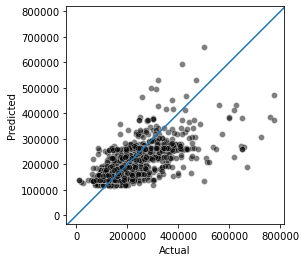

In [29]:
plot_residuals(results_adjusted)

#### Cross Validation

Estimate the expected level of fit of the model using cross validation.

In [30]:
cv_results = cross_validate(lr_model, X_train, y_train, 
                            scoring = 'neg_mean_squared_error', cv = 5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

The mean cross-validation RMSE is:  76097.4945 +/- 7388.8188


### Test Set

#### Predict with Linear Regression

In [31]:
lr_model.fit(X_train, y_train)
y_test_predicted = lr_model.predict(X_test)
metrics(lr_model, y_test_predicted, X_test, y_test)

,RMSE,MAPE,R^2
Linear Regression,70878.411767,42.464558,0.427026


In [32]:
results_test = summarize_results(y_test, y_test_predicted)
results_test.sample(5)

,Actual,Predicted,Difference,Difference_percent
542,168900,275233.805859,106333.805859,62.956664
1187,159000,197223.662813,38223.662813,24.040040
482,295000,268647.149474,26352.850526,8.933170
746,145000,164286.394986,19286.394986,13.300962
229,109900,168120.562468,58220.562468,52.975944


### Visualizing predictions vs actual

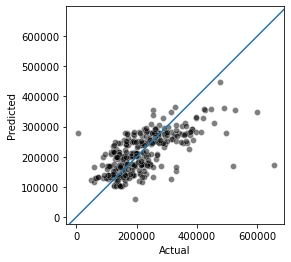

In [33]:
plot_residuals(results_test)

In [34]:
model_transformed_target.fit(X_train, y_train)
y_test_predicted = model_transformed_target.predict(X_test)


In [35]:
metrics(model_transformed_target, y_test_predicted, X_test, y_test)

,RMSE,MAPE,R^2
Linear Regression,71238.361241,39.112031,0.421192


## Support Vector Regressor

#### Support Vector Regressor

Fit our data to a support vector regressor to make predictions. Use RMSE again to evaluate, then cross validate and see how it compares to linear regression.

In [80]:
svm_model = Pipeline([
 ('preprocessor', preprocessor),
 ('regressor', SVR())
])
svm_model.fit(X_train, y_train)
y_train_predicted = svm_model.predict(X_train)

def metrics_cv(model, predictions, X, y):
    cv_results = cross_validate(model, X, y, scoring = 'neg_mean_squared_error', cv = 5)
    RMSE = np.sqrt(mean_squared_error(y, predictions))
    MAPE = (np.mean(np.abs((y - predictions) / y))) * 100
    scores = np.sqrt(-cv_results["test_score"])
    return pd.DataFrame({"RMSE": RMSE, 
                         "MAPE": MAPE, 
                         "CV RMSE:" : f"{scores.mean():.4f}", 
                         "+/-" : f"{scores.std():.4f}"},
                         index = ["Support Vector Machine"])
metrics_cv(svm_model, y_train_predicted, X_train, y_train)

,RMSE,MAPE,CV RMSE:,+/-
Support Vector Machine,102136.893619,38.33009,101816.9385,9743.2811


Our model is not performing well at all compared to Linear Regression. Lets try optimize the hyperparameters of the support vector regressor using grid search.

In [37]:

param_grid = [
 {'regressor__C': [10000, 100000, 1000000, 10000000],
 'regressor__gamma': [1, 10, 100, 'scale', 'auto']},
]
# 5 ^ 3 = 125 iterations.
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train);

In [59]:
grid_search.best_params_

{'regressor__C': 100000, 'regressor__gamma': 'auto'}

The model performs significantly better when the parameters have been tuned well.

In [61]:
y_train_predicted = grid_search.best_estimator_.predict(X_train)
metrics_cv(grid_search.best_estimator_, y_train_predicted, X_train, y_train)


,RMSE,MAPE,CV RMSE:,+/-
Support Vector Machine,72659.435874,26.641135,74433.8396,8772.9318


In [66]:
y_predicted_lr = lr_model.predict(X_test)
y_predicted_svm = svm_model.predict(X_test)
y_predicted_grid_scv = grid_search.best_estimator_.predict(X_test)


Since we are using RMSE to evaluate the models, the best performing model we have is Linear Regression. However, the optimized support vector regressor is unlikely to be statistically different from the linear regression model. 

In [83]:
summary = metrics_cv(lr_model, y_predicted_lr, X_test, y_test).append(
metrics_cv(svm_model, y_predicted_svm, X_test, y_test)).append(
metrics_cv(grid_search.best_estimator_, y_predicted_grid_scv, X_test, y_test))
summary.set_index(pd.Index(['Linear Regression', 'Support Vector Machine', 'Support Vector Machine (Optimized)']))

,RMSE,MAPE,CV RMSE:,+/-
Linear Regression,70878.411767,42.464558,70279.8302,12711.2882
Support Vector Machine,96356.663446,45.505008,95464.9990,6596.9986
Support Vector Machine (Optimized),70944.860430,38.753190,72266.6694,11918.6928


## Discussion

* I have learnt a lot about pre-processing, transformations, training models, testing models, metrics and different cross validations. 

* The biggest thing I struggled with was managing all the code and just knowing what to do next. I had quite an issue with understanding when to use the training data and when to use the testing data for way too long. I fixed all that up, but that was a major setback for the time spent on this assignment. 

* I really enjoyed going through and exploring the data. When analyzing the categorical data, I found it quite interesting to see how some of the features interacted. I looked into correlation and the impact it can have on the model; learning about the affect of multicollinearity. This gave me an idea to feature engineer the features livingArea, bedrooms, rooms and bathrooms in a single feature to see if that would reduce this affect. I think that would have been a fun experiment to explore. I wasn't too sure how to go about this and with my weak structure of code, I found it difficult to find the best way to check out the different variations.

* I wish I had a bit more time to work on this assignment to explore more machine learning models, although I know the general structure is the same. Heading into this next time, I want to brainstorm better ways to structure my code to give the best automation. 